問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [1]:
#80
!wget https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
!unzip /content/news+aggregator.zip

--2024-07-08 05:39:26--  https://archive.ics.uci.edu/static/public/359/news+aggregator.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘news+aggregator.zip’

news+aggregator.zip     [   <=>              ]  27.87M  51.5MB/s    in 0.5s    

2024-07-08 05:39:26 (51.5 MB/s) - ‘news+aggregator.zip’ saved [29224203]

Archive:  /content/news+aggregator.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
【検証データ】
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64
【評価データ】
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64


In [5]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int) #辞書初期化
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('頻度上位20語')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')


ID数: 9377

頻度上位20語
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
of: 9
The: 10
1: 11
To: 12
2: 13
and: 14
the: 15
In: 16
Of: 17
at: 18
a: 19
A: 20


In [6]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [7]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: FOREX-Dollar rises on US rate speculation after Yellen comments
ID列: [55, 59, 161, 4, 7, 234, 3530, 26, 97, 429]


In [8]:
#81
import torch
import torch.nn as nn

vocab_size = 4
emb_dim = 5
embeddings = nn.Embedding(vocab_size, emb_dim)
# 0番目の単語なので，[0]をTensorに変換
word = torch.tensor([0,1,2,3])
embed_word = embeddings(word)
print(embed_word)
print(word.shape, '->', embed_word.shape)

tensor([[ 0.7597, -0.2045, -0.2577,  0.2245, -1.1226],
        [ 1.0200, -1.2710,  0.0566, -1.2004, -0.1507],
        [ 0.5847,  0.8397, -1.1634, -0.7765,  0.3819],
        [-0.2148,  0.7816, -0.2768,  1.5894,  0.6335]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4]) -> torch.Size([4, 5])


In [9]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
    return hidden

In [10]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X.iloc[index]
    inputs = self.tokenizer(text)

    return ({'inputs': torch.tensor(inputs, dtype=torch.int64),'labels': torch.tensor(self.y[index], dtype=torch.int64)})

In [11]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10672
Dataset[index]の出力:
  inputs: tensor([  55,   59,  161,    4,    7,  234, 3530,   26,   97,  429])
  labels: 0


In [12]:
import torch
x = torch.zeros(2, 3, 4, 5, 6)
print(x.size())
print(x.unsqueeze(1).size())
print(x.size())
print(x.size()[0:2])

torch.Size([2, 3, 4, 5, 6])
torch.Size([2, 1, 3, 4, 5, 6])
torch.Size([2, 3, 4, 5, 6])
torch.Size([2, 3])


In [13]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(input)
print("\n")
print(output)

tensor([[-1.3049,  1.0181,  0.4924],
        [-0.9001,  1.3291, -0.4746]])


tensor([[0.0580, 0.5920, 0.3500],
        [0.0846, 0.7860, 0.1294]])


In [14]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs'] #titleのID表記したtensor
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeでバッチの大きさ1を追加

tensor([[0.2413, 0.3772, 0.2529, 0.1285]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1302, 0.2119, 0.2848, 0.3732]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2102, 0.3164, 0.1220, 0.3514]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2192, 0.3151, 0.2845, 0.1812]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3727, 0.3245, 0.1227, 0.1800]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3112, 0.3226, 0.2402, 0.1261]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2120, 0.2444, 0.2365, 0.3071]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2857, 0.2372, 0.3125, 0.1646]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2719, 0.3048, 0.2785, 0.1449]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3448, 0.3059, 0.1831, 0.1661]], grad_fn=<SoftmaxBackward0>)


確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [15]:
#82
a = torch.randn(4, 4)
print(a)
print("\n")
print(torch.argmax(a))

tensor([[-0.6119, -1.5377, -0.1336,  1.1291],
        [-2.5199, -0.1198,  1.8657, -0.4216],
        [ 1.6890, -1.2010, -0.7349,  0.7757],
        [-1.4413, -0.5890, -0.5754, -2.0760]])


tensor(6)


In [16]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader: #バッチごとに取り出して処理
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [17]:

import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [18]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1111, accuracy_train: 0.5230, loss_valid: 1.1237, accuracy_valid: 0.5195, 51.7465sec
epoch: 2, loss_train: 1.0295, accuracy_train: 0.5812, loss_valid: 1.0767, accuracy_valid: 0.5532, 50.7422sec
epoch: 3, loss_train: 0.9089, accuracy_train: 0.6559, loss_valid: 0.9931, accuracy_valid: 0.6229, 55.4887sec
epoch: 4, loss_train: 0.7558, accuracy_train: 0.7268, loss_valid: 0.8922, accuracy_valid: 0.6702, 56.5092sec
epoch: 5, loss_train: 0.6442, accuracy_train: 0.7683, loss_valid: 0.7959, accuracy_valid: 0.7256, 57.7726sec
epoch: 6, loss_train: 0.5720, accuracy_train: 0.7913, loss_valid: 0.7758, accuracy_valid: 0.7346, 55.9762sec
epoch: 7, loss_train: 0.5133, accuracy_train: 0.8126, loss_valid: 0.7337, accuracy_valid: 0.7496, 53.6122sec
epoch: 8, loss_train: 0.4816, accuracy_train: 0.8218, loss_valid: 0.7220, accuracy_valid: 0.7474, 59.8792sec
epoch: 9, loss_train: 0.4645, accuracy_train: 0.8281, loss_valid: 0.7091, accuracy_valid: 0.7526, 53.3305sec
epoch: 10, loss_tra

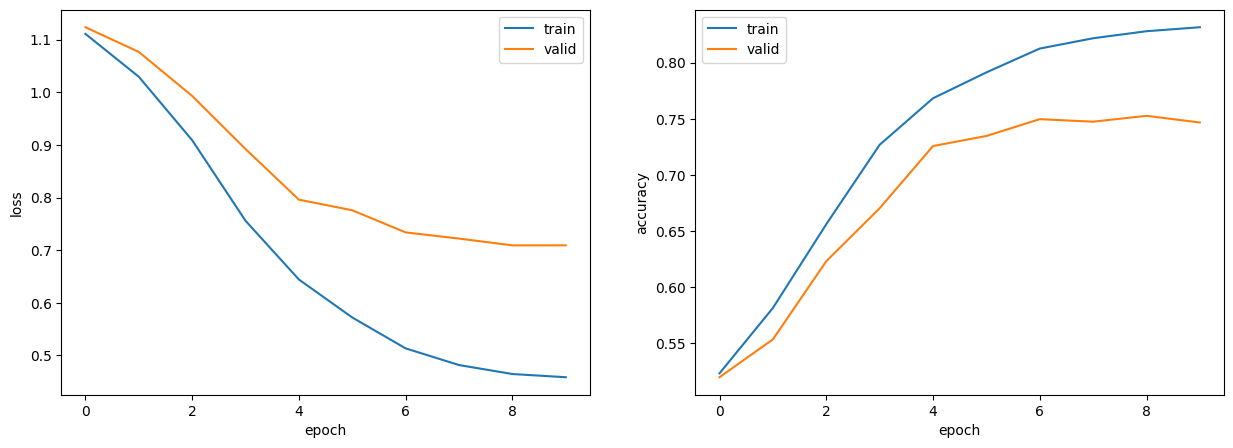

正解率（学習データ）：0.832
正解率（評価データ）：0.775


In [19]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# knock83

In [25]:
#83
import numpy as np
a = np.array([1,2,3,4,5])
print(a.shape[0])

5


In [26]:
a = torch.LongTensor([[2,1], [2, 3]])
print(a)
print(a.dtype)

tensor([[2, 1],
        [2, 3]])
torch.int64


In [27]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx) #最大系列長でpadding
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}


In [32]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_LAYERS=1
# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


epoch: 1, loss_train: 1.2525, accuracy_train: 0.4115, loss_valid: 1.2548, accuracy_valid: 0.3943, 12.3564sec
epoch: 2, loss_train: 1.1720, accuracy_train: 0.5105, loss_valid: 1.1807, accuracy_valid: 0.4888, 11.4536sec
epoch: 3, loss_train: 1.0826, accuracy_train: 0.5883, loss_valid: 1.1278, accuracy_valid: 0.5427, 11.4213sec
epoch: 4, loss_train: 1.0402, accuracy_train: 0.6146, loss_valid: 1.0831, accuracy_valid: 0.5765, 10.9279sec
epoch: 5, loss_train: 0.9893, accuracy_train: 0.6457, loss_valid: 1.0506, accuracy_valid: 0.6102, 10.6652sec
epoch: 6, loss_train: 0.9357, accuracy_train: 0.6773, loss_valid: 1.0040, accuracy_valid: 0.6357, 11.3615sec
epoch: 7, loss_train: 0.8592, accuracy_train: 0.7160, loss_valid: 0.9303, accuracy_valid: 0.6844, 11.4997sec
epoch: 8, loss_train: 0.8347, accuracy_train: 0.7272, loss_valid: 0.9117, accuracy_valid: 0.6919, 11.3773sec
epoch: 9, loss_train: 0.8240, accuracy_train: 0.7197, loss_valid: 0.9307, accuracy_valid: 0.6664, 10.4543sec
epoch: 10, loss_tra

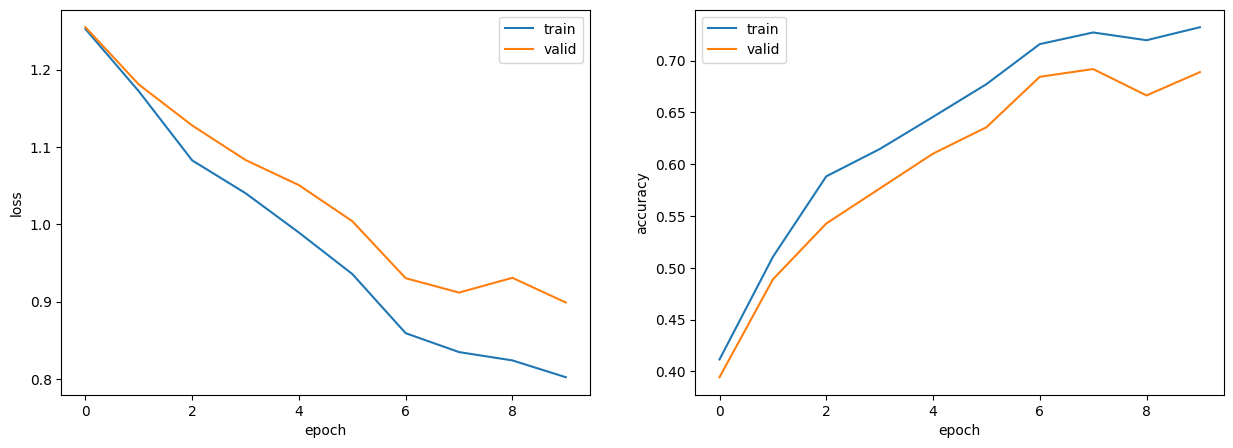

正解率（学習データ）：0.732
正解率（評価データ）：0.700


In [33]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

# knock84

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
#chapter07より
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/NLP100knock/GoogleNews-vectors-negative300.bin.gz', binary=True)


# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300 #学習済みモデルは、各単語を300次元の実数ベクトルで表現
weights = np.zeros((VOCAB_SIZE, EMB_SIZE)) #ゼロで初期化された行列で、後で学習済みベクトルが格納
words_in_pretrained = 0 #学習済みベクトルを持つ単語の数を数えるためのカウンター

#各単語について、学習済みモデル（GoogleのWord2Vec）から対応する単語ベクトルを取得
for i, word in enumerate(word2id.keys()): #word2id = 単語ID辞書　enumerate()関数は、リストやイテラブルの要素とそれに対応するインデックスを順に返します。iはインデックス、wordは単語
  try:
    weights[i] = model[word] #modelwordが学習済みモデル（ここではmodel）に存在する場合、その単語のベクトルをweights
    words_in_pretrained += 1 #words_in_pretrained変数をインクリメントして、学習済みのベクトルを持つ単語の数をカウントします。
  except KeyError: #単語が学習済みモデルに存在しない場合
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,)) #学習済みモデルにwordが存在しない場合、代わりにランダムなノイズを持つベクトルをweightsのi番目の行に代入
#NumPyの配列 weights をPyTorchのテンソルに変換
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9147 / 9378
torch.Size([9378, 300])


In [23]:
# クラスの定義
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2 bool型 False == 0 True == 1
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

In [30]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) #パディングトークンのインデックスです。語彙のサイズをパディングトークンとして設定
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)
#RNNクラスのインスタンス化: 先ほど定義したパラメータを使用して、RNN クラスのインスタンス model を生成しています。
#emb_weights=weights により、事前学習済みの単語埋め込みベクトルを指定しています。

# 損失関数の定義
criterion = nn.CrossEntropyLoss() #分類問題の場合に一般的に使用されるクロスエントロピー損失関数

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) #最適化アルゴリズム

# デバイスの指定
#device = torch.device('cuda') デバイスについては省略

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
#train_model 関数を使用して、dataset_train を用いてモデルを学習。以降は渡されたパラメータ

epoch: 1, loss_train: 1.2639, accuracy_train: 0.3981, loss_valid: 1.3041, accuracy_valid: 0.3981, 13.8862sec
epoch: 2, loss_train: 1.0807, accuracy_train: 0.5966, loss_valid: 1.1101, accuracy_valid: 0.5720, 11.9852sec
epoch: 3, loss_train: 1.0687, accuracy_train: 0.5886, loss_valid: 1.1167, accuracy_valid: 0.5622, 11.5552sec
epoch: 4, loss_train: 0.9886, accuracy_train: 0.6430, loss_valid: 1.0360, accuracy_valid: 0.6207, 10.8411sec
epoch: 5, loss_train: 1.1166, accuracy_train: 0.5573, loss_valid: 1.1856, accuracy_valid: 0.5322, 11.4808sec
epoch: 6, loss_train: 1.0198, accuracy_train: 0.6111, loss_valid: 1.0752, accuracy_valid: 0.5862, 11.7831sec
epoch: 7, loss_train: 0.9687, accuracy_train: 0.6352, loss_valid: 1.0566, accuracy_valid: 0.5900, 11.8311sec
epoch: 8, loss_train: 0.9853, accuracy_train: 0.6277, loss_valid: 1.0630, accuracy_valid: 0.5832, 11.1497sec
epoch: 9, loss_train: 1.0019, accuracy_train: 0.6204, loss_valid: 1.0889, accuracy_valid: 0.5780, 11.5875sec
epoch: 10, loss_tra

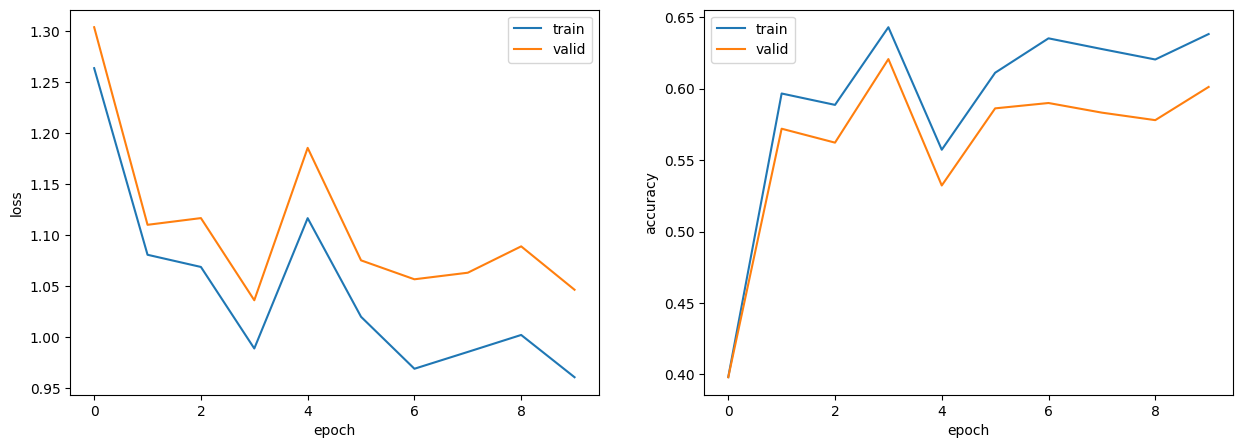

正解率（学習データ）：0.638
正解率（評価データ）：0.619


In [31]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')